In [1]:

from processing_functions import *
from comparison_datasets import *
import matplotlib as mpl
import seaborn as sns
new_rc_params = {'text.usetex': False,
"svg.fonttype": 'none'
}
mpl.rcParams.update(new_rc_params)



In [5]:

woolfsons = ['AN4', 'AN35', 'AN3', 'BN4', 'BN35', 'BN3']

just_kds = woolfson_plaper_ppi_kds()
just_kds['kd_nm'] = just_kds['kd']/(10**-9)
just_kds['kd_error_nm'] = just_kds['kd_error']/(10**-9)
just_kds['log2_enrich'] = np.log(just_kds['kd_nm'])


          PPI  log2_enrich_ADDBD  log2_enrich_DBDAD
0    AN35:AN4          -0.977499          -0.882139
1     AN3:AN4          -1.651579          -1.547645
2     AN4:BN4           4.562759           4.525394
3    AN4:BN35           3.600742           3.539114
4     AN4:BN3           0.695434           0.567078
5    AN3:AN35          -3.392707          -1.074697
6    AN35:BN4           0.581788           2.231373
7   AN35:BN35           0.454173          -1.170910
8    AN35:BN3          -2.363262          -3.325710
9     AN3:BN4          -2.473293          -3.384203
10   AN3:BN35          -0.943921          -3.530879
11    AN3:BN3          -4.015110          -3.248745
12   BN35:BN4          -1.864193          -3.423917
13    BN3:BN4          -3.287968          -1.176504
14   BN3:BN35           0.213167          -4.073428
15  AN35:AN35          -3.172425          -3.172425
16    AN3:AN3          -3.628784          -3.628784
17    BN4:BN4          -0.737457          -0.737457
18  BN35:BN3

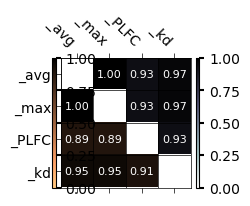

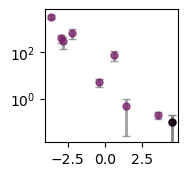

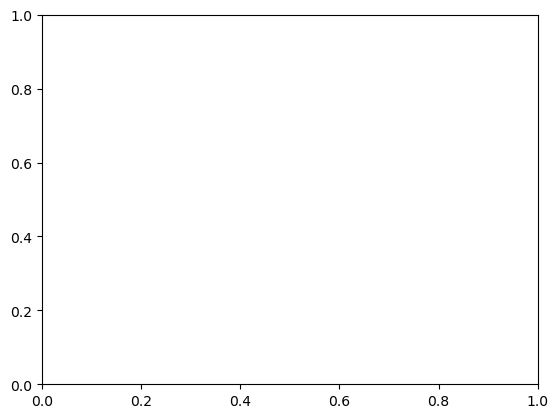

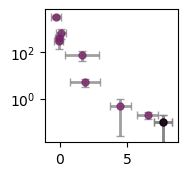

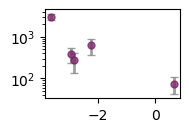

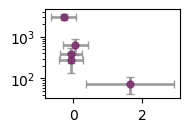

In [15]:
#max of 3 replicates
#load values for comparison 
deseq_homo_af_batch = pd.read_csv('../processing_pipeline/merged_replicates/deseq_plaper_3_smaller_psuedoreplicate_autotune.csv')
deseq_homo_af_batch = deseq_homo_af_batch.rename(columns = {'Unnamed: 0': 'PPI'})
deseq_homo_af_batch['log2_enrich'] = deseq_homo_af_batch['ashr_log2FoldChange_HIS_TRP']

#making enrichment values 
flat_df = pd.read_csv('../processing_pipeline/merged_replicates/plaper_3_smaller_flat_autotune.csv')
flat_df = flat_df.rename(columns = {'Unnamed: 0': 'PPI'})
flat_df['DBD'] = flat_df.PPI.apply(lambda x: x.split(':')[1])
flat_df['AD'] = flat_df.PPI.apply(lambda x: x.split(':')[3])

vals_counts = ['trp1_l68', 'his1_l68', 'trp1_new_1_smaller', 'his1_new_1_smaller',  'trp1_new_2_smaller', 'his1_new_2_smaller', ]
for vc in vals_counts:
    flat_df.loc[flat_df[vc]  == 0, vc] = None

#calculating per replicate enrichments 
flat_df['lin_enrich'] = calc_lin_enrichment(flat_df['trp1_l68'], flat_df['his1_l68'])
flat_df['log2_enrich'] = calc_log2_enrichment(flat_df['lin_enrich'])
flat_df.loc[(flat_df.trp1_l68.isna()) & (flat_df.his1_l68.isna()), 'lin_enrich'] = None
flat_df.loc[(flat_df.trp1_l68.isna()) & (flat_df.his1_l68.isna()), 'log2_enrich'] = None

flat_df['lin_enrich_2'] = calc_lin_enrichment(flat_df['trp1_new_1_smaller'], flat_df['his1_new_1_smaller'])
flat_df['log2_enrich_2'] = calc_log2_enrichment(flat_df['lin_enrich_2'])
flat_df.loc[(flat_df.trp1_new_1_smaller.isna()) & (flat_df.his1_new_1_smaller.isna()), 'lin_enrich_2'] = None
flat_df.loc[(flat_df.trp1_new_1_smaller.isna()) & (flat_df.his1_new_1_smaller.isna()), 'log2_enrich_2'] = None

flat_df['lin_enrich_3'] = calc_lin_enrichment(flat_df['trp1_new_2_smaller'], flat_df['his1_new_2_smaller'])
flat_df['log2_enrich_3'] = calc_log2_enrichment(flat_df['lin_enrich_3'])
flat_df.loc[(flat_df.trp1_new_2_smaller.isna()) & (flat_df.his1_new_2_smaller.isna()), 'lin_enrich_3'] = None
flat_df.loc[(flat_df.trp1_new_2_smaller.isna()) & (flat_df.his1_new_2_smaller.isna()), 'log2_enrich_3'] = None

flat_df = flat_df.dropna()
#average all enrichments together


flat_df['averaged_lin'] = (flat_df['lin_enrich'] + flat_df['lin_enrich_2'] + flat_df['lin_enrich_3'])/3
flat_df['log2_enrich'] = calc_log2_enrichment(flat_df['averaged_lin'])
#flat_df['max_lin'] = flat_df.apply(lambda row: max([row['lin_enrich'] , row['lin_enrich_2'] , row['lin_enrich_3']]), axis = 1)
#flat_df['log2_enrich'] = calc_log2_enrichment(flat_df['max_lin'])

log_2_enrich_avg = split_by_orientations(flat_df, woolfsons, 'log2_enrich', True)
print (log_2_enrich_avg[['PPI', 'log2_enrich_ADDBD', 'log2_enrich_DBDAD']])
log_2_enrich_avg['log2_enrich'] = log_2_enrich_avg.apply(lambda row: np.nanmean([row['log2_enrich_ADDBD'], row['log2_enrich_DBDAD']]), axis = 1)
log_2_enrich_max = split_by_orientations(flat_df, woolfsons, 'log2_enrich', True)
log_2_enrich_max['log2_enrich'] = log_2_enrich_max.apply(lambda row: np.nanmean([row['log2_enrich_ADDBD'], row['log2_enrich_DBDAD']]), axis = 1)

merged = log_2_enrich_avg.merge(log_2_enrich_max, on = 'PPI', suffixes= ['_avg', '_max'], how = 'right')
merged = deseq_homo_af_batch.merge(merged, on = 'PPI', how = 'right')
merged = just_kds.merge(merged, on  = 'PPI', suffixes = [ '_PLFC', '_kd'])

#sort and only look at lower points (max is under detection lim)

combos = list(combinations(['_avg', '_max', '_PLFC', '_kd'], 2))
#sorted_values = merged.sort_values('kd_nm', ascending = False).reindex()

df_to_graph = pd.DataFrame({'PPI':[], 'correl':[], 'rho':[]})
for a, b in combos:
        df_to_graph.loc[df_to_graph.shape[0]] = [make_ppi(a,b), get_correls(merged, 'log2_enrich' + a, 'log2_enrich' + b, False)[2], 
                                                 np.abs(get_correls(merged, 'log2_enrich' + a, 'log2_enrich' + b, False)[3])]


order_libraries = [ '_avg', '_max', '_PLFC', '_kd']
x = make_specific_order_lower_triangle(order_libraries, df_to_graph, 'correl',  get_diag = False)
y = make_specific_order_lower_triangle(order_libraries, df_to_graph, 'rho',  get_diag = False)
y = y.T
make_double_heatmap(x, y, order_libraries, 'copper_r', 'bone_r', size_1 = 2.5, size_2 = 2.5, show_names = True, annot = True, font_size = 8, saveName= 'correls_kd_woolfson.svg', show=False)

off_targets = "#782167ff"

f, ax = plt.subplots()
plt.errorbar(y = merged['kd_nm'],
             x = merged['log2_enrich_avg'], 
             yerr= merged['kd_error_nm'],
             fmt="o", elinewidth = 2, alpha = 0.75, color = off_targets, capsize = 3, markersize = 5, ecolor = 'gray')
plt.errorbar(y = merged.iloc[-1]['kd_nm'],
             x = merged.iloc[-1]['log2_enrich_avg'], 
             yerr= merged.iloc[-1]['kd_error_nm'],
             fmt="o", elinewidth = 2, alpha = 0.75, color = 'black', capsize = 3, markersize = 5, ecolor = 'gray')
plt.yscale('log')
plt.tight_layout()
f.set_size_inches(1.5,1.5)
plt.savefig('./figures/woolfson_kd_correlations_avg.svg', dpi = 300)
#plt.show()

f, ax = plt.subplots()

f, ax = plt.subplots()
plt.errorbar(y = merged['kd_nm'],
             x = merged['ashr_log2FoldChange_HIS_TRP'], 
             xerr= merged['ashr_lfcSE_HIS_TRP'], 
             yerr= merged['kd_error_nm'],
             fmt="o", elinewidth = 2, alpha = 0.75, color = off_targets, capsize = 3, markersize = 5, ecolor = 'gray')
plt.errorbar(y = merged.iloc[-1]['kd_nm'],
             x = merged.iloc[-1]['ashr_log2FoldChange_HIS_TRP'], 
             xerr= merged.iloc[-1]['ashr_lfcSE_HIS_TRP'], 
             yerr= merged.iloc[-1]['kd_error_nm'],
             fmt="o", elinewidth = 2, alpha = 0.75, color = 'black', capsize = 3, markersize = 5, ecolor = 'gray')
plt.yscale('log')
plt.tight_layout()
f.set_size_inches(1.5,1.5)
plt.savefig('./figures/woolfson_kd_correlations_plfc.svg', dpi = 300)
#plt.show()


#look at lower points only
sorted_values = merged.sort_values('kd_nm', ascending = False).reindex()

f, ax = plt.subplots()
plt.errorbar(y = sorted_values.iloc[0:5]['kd_nm'],
             x = sorted_values.iloc[0:5]['log2_enrich_avg'], 
             yerr= sorted_values.iloc[0:5]['kd_error_nm'],
             fmt="o", elinewidth = 2, alpha = 0.75, color = off_targets, capsize = 3, markersize = 5, ecolor = 'gray')
plt.yscale('log')
plt.tight_layout()
f.set_size_inches(1.5,1)
plt.savefig('./figures/woolfson_kd_correlations_avg_small.svg', dpi = 300)

print (get_correls(sorted_values.iloc[0:5],  'log2_enrich_avg','kd_nm',  True))


f, ax = plt.subplots()
plt.errorbar(y = sorted_values.iloc[0:5]['kd_nm'],
             x = sorted_values.iloc[0:5]['ashr_log2FoldChange_HIS_TRP'], 
             yerr= sorted_values.iloc[0:5]['kd_error_nm'],
             xerr=sorted_values.iloc[0:5]['ashr_lfcSE_HIS_TRP'], 
             fmt="o", elinewidth = 2, alpha = 0.75, color = off_targets, capsize = 3, markersize = 5, ecolor = 'gray')
plt.yscale('log')
plt.tight_layout()
f.set_size_inches(1.5,1)
plt.savefig('./figures/woolfson_kd_correlation_plfc_small.svg', dpi = 300)


print (get_correls(sorted_values.iloc[0:5], 'ashr_log2FoldChange_HIS_TRP',  'kd_nm', True))


          PPI  log2_enrich_ADDBD  log2_enrich_DBDAD
0    AN35:AN4           0.238596           0.360998
1     AN3:AN4          -0.404656          -0.282489
2     AN4:BN4           5.227895           5.260810
3    AN4:BN35           3.787614           3.820529
4     AN4:BN3           2.221918           2.089738
5    AN3:AN35          -3.287076           0.310520
6    AN35:BN4           1.483849           3.606457
7   AN35:BN35           1.482066          -0.399096
8    AN35:BN3          -1.079700          -3.088949
9     AN3:BN4          -1.994297          -3.188507
10   AN3:BN35           0.336538          -3.463302
11    AN3:BN3          -3.784382          -2.545193
12   BN35:BN4          -0.834615          -3.100737
13    BN3:BN4          -3.160409          -0.156150
14   BN3:BN35           1.743139          -3.690132
15  AN35:AN35          -2.405212          -2.405212
16    AN3:AN3          -2.891731          -2.891731
17    BN4:BN4           0.253494           0.253494
18  BN35:BN3

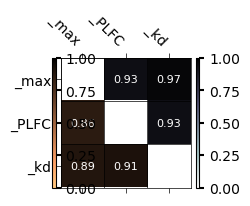

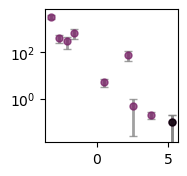

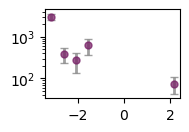

In [14]:
flat_df['max_lin'] = flat_df.apply(lambda row: max([row['lin_enrich'] , row['lin_enrich_2'] , row['lin_enrich_3']]), axis = 1)
flat_df['log2_enrich'] = calc_log2_enrichment(flat_df['max_lin'])

log_2_enrich_avg = split_by_orientations(flat_df, woolfsons, 'log2_enrich', True)
print (log_2_enrich_avg[['PPI', 'log2_enrich_ADDBD', 'log2_enrich_DBDAD']])
log_2_enrich_avg['log2_enrich'] = log_2_enrich_avg.apply(lambda row: np.nanmean([row['log2_enrich_ADDBD'], row['log2_enrich_DBDAD']]), axis = 1)
log_2_enrich_max = split_by_orientations(flat_df, woolfsons, 'log2_enrich', True)
log_2_enrich_max['log2_enrich'] = log_2_enrich_max.apply(lambda row: np.nanmean([row['log2_enrich_ADDBD'], row['log2_enrich_DBDAD']]), axis = 1)

merged = log_2_enrich_avg.merge(log_2_enrich_max, on = 'PPI', suffixes= ['_avg', '_max'], how = 'right')
merged = deseq_homo_af_batch.merge(merged, on = 'PPI', how = 'right')
merged = just_kds.merge(merged, on  = 'PPI', suffixes = [ '_PLFC', '_kd'])

#sort and only look at lower points (max is under detection lim)

combos = list(combinations(['_max', '_PLFC', '_kd'], 2))

df_to_graph = pd.DataFrame({'PPI':[], 'correl':[], 'rho':[]})
for a, b in combos:
        df_to_graph.loc[df_to_graph.shape[0]] = [make_ppi(a,b), get_correls(merged, 'log2_enrich' + a, 'log2_enrich' + b, False)[2], 
                                                 np.abs(get_correls(merged, 'log2_enrich' + a, 'log2_enrich' + b, False)[3])]


order_libraries = [ '_max', '_PLFC', '_kd']
x = make_specific_order_lower_triangle(order_libraries, df_to_graph, 'correl',  get_diag = False)
y = make_specific_order_lower_triangle(order_libraries, df_to_graph, 'rho',  get_diag = False)
y = y.T
make_double_heatmap(x, y, order_libraries, 'copper_r', 'bone_r', size_1 = 2.5, size_2 = 2.5, show_names = True, annot = True, font_size = 8, saveName= 'correls_kd_woolfson.svg', show=False)

off_targets = "#782167ff"




f, ax = plt.subplots()
plt.errorbar(y = merged['kd_nm'],
             x = merged['log2_enrich_max'], 
             yerr= merged['kd_error_nm'],
             fmt="o", elinewidth = 2, alpha = 0.75, color = off_targets, capsize = 3, markersize = 5, ecolor = 'gray')
plt.errorbar(y = merged.iloc[-1]['kd_nm'],
             x = merged.iloc[-1]['log2_enrich_max'], 
             yerr= merged.iloc[-1]['kd_error_nm'],
             fmt="o", elinewidth = 2, alpha = 0.75, color = 'black', capsize = 3, markersize = 5, ecolor = 'gray')
plt.yscale('log')
plt.tight_layout()
f.set_size_inches(1.5,1.5)
plt.savefig('./figures/woolfson_kd_correlation_max.svg', dpi = 300)
#plt.show()

#look at lower points only
sorted_values = merged.sort_values('kd_nm', ascending = False).reindex()

f, ax = plt.subplots()
plt.errorbar(y = sorted_values.iloc[0:5]['kd_nm'],
             x = sorted_values.iloc[0:5]['log2_enrich_max'], 
             yerr= sorted_values.iloc[0:5]['kd_error_nm'],
             fmt="o", elinewidth = 2, alpha = 0.75, color = off_targets, capsize = 3, markersize = 5, ecolor = 'gray')
plt.yscale('log')
plt.tight_layout()
f.set_size_inches(1.5,1)
plt.savefig('./figures/woolfson_kd_correlation_max_small.svg', dpi = 300)

print (get_correls(sorted_values.iloc[0:5],  'log2_enrich_max', 'kd_nm', True))
